# Training U-Net model
## 250 Epochs, No Dropout, Adam Optimizer, Learning Rate 1e-3

In [1]:
import sys
sys.path.append("..")
import os, re, glob
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from src import data,unet

Using TensorFlow backend.


In [2]:
from keras import utils
train_dir = "/home/ubuntu/TrainingSet"
weight_file = 'saved_models/endo_models/weights-500Epochs-NoDrop-Adam3.hdf5'
epi_weight_file = 'saved_models/epi_models/weights-500Epochs-NoDrop-Adam3.hdf5'
save_imgs_dir = 'images/train500NoDrpAdam3/endo_images'
save_imgs_dir_epi = 'images/train500NoDrpAdam3/epi_images'

images = []
inner_masks = []
outer_masks = []

patient_directories = sorted(glob.glob(os.path.join(train_dir, "patient*")))

for patient_dir in patient_directories:
    imgdata = data.ImageData(patient_dir)
    images += imgdata.labeled_images
    inner_masks += imgdata.endo_masks
    outer_masks += imgdata.epi_masks

images = np.asarray(images)[:,:,:,None].astype('float64')
i_masks = np.asarray(inner_masks)
o_masks = np.asarray(outer_masks)

dims = i_masks.shape
classes = len(set(i_masks[0].flatten()))
new_shape = dims + (classes,)
i_masks = utils.to_categorical(i_masks).reshape(new_shape)
o_masks = utils.to_categorical(o_masks).reshape(new_shape)

#i_masks_cropped=[]
#crop_x = 8

#for mask in i_masks:
#    i_masks_cropped.append(mask[0+crop_x//2:216-crop_x//2,:,:])

#print(i_masks[0].shape)
#print(i_masks_cropped[0].shape)

#i_masks_final = np.asarray(i_masks_cropped)



def normalize(x, epsilon=1e-7, axis=(1,2)):
    x -= np.mean(x, axis=axis, keepdims=True)
    x /= np.std(x, axis=axis, keepdims=True) + epsilon
    
normalize(images,axis=(1,2))

print("There are %d total training images." % len(images))
print("There are %d total inner masks." % len(inner_masks))
print("There are %d total outer masks." % len(outer_masks))

There are 243 total training images.
There are 243 total inner masks.
There are 243 total outer masks.


In [3]:
height,width,_ = images[0].shape
dropout = 0.0
unet_conv = unet.UNet()

model_endo = unet_conv.get_unet(height=height, width=width, channels=1,features=32,steps=3,dropout=dropout,padding='same')
model_endo.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 216, 256, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 216, 256, 32) 320         input_1[0][0]                    
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 216, 256, 32) 0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 216, 256, 32) 0           activation_1[0][0]               
__________________________________________________________________________________________________
conv2d_2 (

In [4]:
from keras.optimizers import Adam, SGD
from keras import backend as K

def dice_coef(y_true, y_pred):
    flat_y_true = K.flatten(y_true)
    flat_y_pred = K.flatten(y_pred)
    intersection = K.sum(flat_y_true * flat_y_pred)
    return (2. * intersection + 1.) / (K.sum(flat_y_true) + K.sum(flat_y_pred) + 1.)

def dice_coef_np(y_true, y_pred):
    intersection = np.sum(y_true * y_pred)
    return (2. * intersection + 1.) / (np.sum(y_true) + np.sum(y_pred) + 1.)


def pixelwise_crossentropy(y_true, y_pred, weights=[0.5,0.5], epsilon=1e-8):
    ndim = K.ndim(y_pred)
    ncategory = K.int_shape(y_pred)[-1]
    # scale predictions so class probabilities of each pixel sum to 1
    y_pred /= K.sum(y_pred, axis=(ndim-1), keepdims=True)
    y_pred = K.clip(y_pred, epsilon, 1-epsilon)
    w = K.constant(weights) * (ncategory / sum(weights))
    # first, average over all axis except classes
    cross_entropies = -K.mean(y_true * K.log(y_pred), axis=tuple(range(ndim-1)))
    return K.sum(w * cross_entropies)


In [5]:
model_endo.compile(optimizer=Adam(lr=1e-3),loss=[pixelwise_crossentropy],metrics=[dice_coef])

In [6]:
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint

from math import ceil

seed = 78

validation_split = 0.2

epochs = 500
batch_size = 32


split_index = int((1 - validation_split) * len(images))

train_steps = ceil(split_index / batch_size)
val_steps = ceil((len(images)-split_index )/batch_size)

train_images = images[:split_index]
train_inner_masks = i_masks[:split_index]
train_outer_masks = o_masks[:split_index]

validation_images = images[split_index:]
validation_inner_masks = i_masks[split_index:]
validation_outer_masks = o_masks[split_index:]


data_gen_args = dict(rotation_range=180,
                     width_shift_range=0.1,
                     height_shift_range=0.1,
                     shear_range=0.1,
                     zoom_range=0.01,
                     fill_mode='nearest')

train_images_datagen = ImageDataGenerator(**data_gen_args)
train_masks_datagen = ImageDataGenerator(**data_gen_args)


#seed = 1
#height,width,channels = train_images[0].shape
#print(train_images[0].shape)
#print(train_inner_masks[0].shape)
train_images_datagen.fit(train_images,augment=True,seed=seed)
train_masks_datagen.fit(train_inner_masks,augment=True,seed=seed)

train_images_generator = train_images_datagen.flow(train_images, y=None, seed=seed)
train_masks_generator = train_images_datagen.flow(train_inner_masks, y=None, seed=seed)


train_generator = zip(train_images_generator, train_masks_generator)

/usr/local/lib/python3.5/dist-packages/Keras-2.1.3-py3.5.egg/keras/preprocessing/image.py:722: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (194, 216, 256, 2) (2 channels).
/usr/local/lib/python3.5/dist-packages/Keras-2.1.3-py3.5.egg/keras/preprocessing/image.py:896: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (194, 216, 256, 2) (2 channels).


In [7]:
#K.clear_session()

checkpointer = ModelCheckpoint(filepath=weight_file, verbose=1, save_best_only=True)

hist = model_endo.fit_generator(train_generator,steps_per_epoch=train_steps,epochs=epochs,verbose=1,callbacks=[checkpointer],
                   validation_data=(validation_images,validation_inner_masks),validation_steps=val_steps)

Epoch 1/500
6/7 [========================>.....] - ETA: 2s - loss: 0.6387 - dice_coef: 0.6331
Epoch 00001: val_loss improved from inf to 0.24278, saving model to saved_models/endo_models/weights-500Epochs-NoDrop-Adam3.hdf5
7/7 [==============================] - 20s 3s/step - loss: 0.5704 - dice_coef: 0.6704 - val_loss: 0.2428 - val_dice_coef: 0.8727
Epoch 2/500
6/7 [========================>.....] - ETA: 1s - loss: 0.2152 - dice_coef: 0.8759
Epoch 00002: val_loss improved from 0.24278 to 0.14902, saving model to saved_models/endo_models/weights-500Epochs-NoDrop-Adam3.hdf5
7/7 [==============================] - 8s 1s/step - loss: 0.2127 - dice_coef: 0.8803 - val_loss: 0.1490 - val_dice_coef: 0.9139
Epoch 3/500
6/7 [========================>.....] - ETA: 1s - loss: 0.1625 - dice_coef: 0.8981
Epoch 00003: val_loss did not improve
7/7 [==============================] - 7s 1s/step - loss: 0.1690 - dice_coef: 0.8957 - val_loss: 0.1499 - val_dice_coef: 0.9062
Epoch 4/500
6/7 [================

Epoch 27/500
6/7 [========================>.....] - ETA: 1s - loss: 0.1121 - dice_coef: 0.9289
Epoch 00027: val_loss improved from 0.10021 to 0.09845, saving model to saved_models/endo_models/weights-500Epochs-NoDrop-Adam3.hdf5
7/7 [==============================] - 8s 1s/step - loss: 0.1117 - dice_coef: 0.9308 - val_loss: 0.0985 - val_dice_coef: 0.9435
Epoch 28/500
6/7 [========================>.....] - ETA: 1s - loss: 0.1126 - dice_coef: 0.9281
Epoch 00028: val_loss did not improve
7/7 [==============================] - 8s 1s/step - loss: 0.1054 - dice_coef: 0.9317 - val_loss: 0.0994 - val_dice_coef: 0.9345
Epoch 29/500
6/7 [========================>.....] - ETA: 1s - loss: 0.1123 - dice_coef: 0.9331
Epoch 00029: val_loss improved from 0.09845 to 0.09691, saving model to saved_models/endo_models/weights-500Epochs-NoDrop-Adam3.hdf5
7/7 [==============================] - 8s 1s/step - loss: 0.1096 - dice_coef: 0.9342 - val_loss: 0.0969 - val_dice_coef: 0.9407
Epoch 30/500
6/7 [=========

Epoch 57/500
6/7 [========================>.....] - ETA: 1s - loss: 0.1121 - dice_coef: 0.9315
Epoch 00057: val_loss did not improve
7/7 [==============================] - 8s 1s/step - loss: 0.1085 - dice_coef: 0.9326 - val_loss: 0.0976 - val_dice_coef: 0.9339
Epoch 58/500
6/7 [========================>.....] - ETA: 1s - loss: 0.1059 - dice_coef: 0.9326
Epoch 00058: val_loss did not improve
7/7 [==============================] - 8s 1s/step - loss: 0.1019 - dice_coef: 0.9351 - val_loss: 0.0970 - val_dice_coef: 0.9388
Epoch 59/500
6/7 [========================>.....] - ETA: 1s - loss: 0.1016 - dice_coef: 0.9352
Epoch 00059: val_loss did not improve
7/7 [==============================] - 8s 1s/step - loss: 0.0980 - dice_coef: 0.9374 - val_loss: 0.0978 - val_dice_coef: 0.9411
Epoch 60/500
6/7 [========================>.....] - ETA: 1s - loss: 0.1013 - dice_coef: 0.9354
Epoch 00060: val_loss did not improve
7/7 [==============================] - 8s 1s/step - loss: 0.0995 - dice_coef: 0.9367

Epoch 86/500
6/7 [========================>.....] - ETA: 1s - loss: 0.0700 - dice_coef: 0.9622
Epoch 00086: val_loss improved from 0.08250 to 0.07988, saving model to saved_models/endo_models/weights-500Epochs-NoDrop-Adam3.hdf5
7/7 [==============================] - 8s 1s/step - loss: 0.0687 - dice_coef: 0.9617 - val_loss: 0.0799 - val_dice_coef: 0.9477
Epoch 87/500
6/7 [========================>.....] - ETA: 1s - loss: 0.0710 - dice_coef: 0.9541
Epoch 00087: val_loss did not improve
7/7 [==============================] - 8s 1s/step - loss: 0.0670 - dice_coef: 0.9566 - val_loss: 0.0800 - val_dice_coef: 0.9592
Epoch 88/500
6/7 [========================>.....] - ETA: 1s - loss: 0.0680 - dice_coef: 0.9616
Epoch 00088: val_loss improved from 0.07988 to 0.07807, saving model to saved_models/endo_models/weights-500Epochs-NoDrop-Adam3.hdf5
7/7 [==============================] - 8s 1s/step - loss: 0.0660 - dice_coef: 0.9628 - val_loss: 0.0781 - val_dice_coef: 0.9558
Epoch 89/500
6/7 [=========

Epoch 144/500
6/7 [========================>.....] - ETA: 1s - loss: 0.0305 - dice_coef: 0.9838
Epoch 00144: val_loss did not improve
7/7 [==============================] - 8s 1s/step - loss: 0.0294 - dice_coef: 0.9838 - val_loss: 0.0401 - val_dice_coef: 0.9814
Epoch 145/500
6/7 [========================>.....] - ETA: 1s - loss: 0.0294 - dice_coef: 0.9821
Epoch 00145: val_loss did not improve
7/7 [==============================] - 8s 1s/step - loss: 0.0328 - dice_coef: 0.9810 - val_loss: 0.0360 - val_dice_coef: 0.9810
Epoch 146/500
6/7 [========================>.....] - ETA: 1s - loss: 0.0339 - dice_coef: 0.9798
Epoch 00146: val_loss did not improve
7/7 [==============================] - 8s 1s/step - loss: 0.0344 - dice_coef: 0.9790 - val_loss: 0.0537 - val_dice_coef: 0.9703
Epoch 147/500
6/7 [========================>.....] - ETA: 1s - loss: 0.0331 - dice_coef: 0.9808
Epoch 00147: val_loss did not improve
7/7 [==============================] - 8s 1s/step - loss: 0.0327 - dice_coef: 0.

Epoch 175/500
6/7 [========================>.....] - ETA: 1s - loss: 0.0279 - dice_coef: 0.9835
Epoch 00175: val_loss did not improve
7/7 [==============================] - 8s 1s/step - loss: 0.0323 - dice_coef: 0.9818 - val_loss: 0.0362 - val_dice_coef: 0.9827
Epoch 176/500
6/7 [========================>.....] - ETA: 1s - loss: 0.0309 - dice_coef: 0.9827
Epoch 00176: val_loss did not improve
7/7 [==============================] - 8s 1s/step - loss: 0.0300 - dice_coef: 0.9831 - val_loss: 0.0330 - val_dice_coef: 0.9827
Epoch 177/500
6/7 [========================>.....] - ETA: 1s - loss: 0.0323 - dice_coef: 0.9805
Epoch 00177: val_loss did not improve
7/7 [==============================] - 8s 1s/step - loss: 0.0306 - dice_coef: 0.9812 - val_loss: 0.0366 - val_dice_coef: 0.9810
Epoch 178/500
6/7 [========================>.....] - ETA: 1s - loss: 0.0275 - dice_coef: 0.9843
Epoch 00178: val_loss did not improve
7/7 [==============================] - 8s 1s/step - loss: 0.0328 - dice_coef: 0.

Epoch 236/500
6/7 [========================>.....] - ETA: 1s - loss: 0.0161 - dice_coef: 0.9903
Epoch 00236: val_loss did not improve
7/7 [==============================] - 8s 1s/step - loss: 0.0154 - dice_coef: 0.9905 - val_loss: 0.0278 - val_dice_coef: 0.9871
Epoch 237/500
6/7 [========================>.....] - ETA: 1s - loss: 0.0162 - dice_coef: 0.9906
Epoch 00237: val_loss did not improve
7/7 [==============================] - 8s 1s/step - loss: 0.0167 - dice_coef: 0.9904 - val_loss: 0.0279 - val_dice_coef: 0.9876
Epoch 238/500
6/7 [========================>.....] - ETA: 1s - loss: 0.0173 - dice_coef: 0.9898
Epoch 00238: val_loss improved from 0.02630 to 0.02608, saving model to saved_models/endo_models/weights-500Epochs-NoDrop-Adam3.hdf5
7/7 [==============================] - 8s 1s/step - loss: 0.0162 - dice_coef: 0.9903 - val_loss: 0.0261 - val_dice_coef: 0.9879
Epoch 239/500
6/7 [========================>.....] - ETA: 1s - loss: 0.0169 - dice_coef: 0.9899
Epoch 00239: val_loss d

Epoch 267/500
6/7 [========================>.....] - ETA: 1s - loss: 0.0159 - dice_coef: 0.9907
Epoch 00267: val_loss did not improve
7/7 [==============================] - 8s 1s/step - loss: 0.0159 - dice_coef: 0.9906 - val_loss: 0.0265 - val_dice_coef: 0.9872
Epoch 268/500
6/7 [========================>.....] - ETA: 1s - loss: 0.0156 - dice_coef: 0.9903
Epoch 00268: val_loss improved from 0.02560 to 0.02553, saving model to saved_models/endo_models/weights-500Epochs-NoDrop-Adam3.hdf5
7/7 [==============================] - 8s 1s/step - loss: 0.0163 - dice_coef: 0.9903 - val_loss: 0.0255 - val_dice_coef: 0.9883
Epoch 269/500
6/7 [========================>.....] - ETA: 1s - loss: 0.0198 - dice_coef: 0.9893
Epoch 00269: val_loss did not improve
7/7 [==============================] - 8s 1s/step - loss: 0.0211 - dice_coef: 0.9883 - val_loss: 0.0488 - val_dice_coef: 0.9762
Epoch 270/500
6/7 [========================>.....] - ETA: 1s - loss: 0.0214 - dice_coef: 0.9877
Epoch 00270: val_loss d

Epoch 297/500
6/7 [========================>.....] - ETA: 1s - loss: 0.0141 - dice_coef: 0.9914
Epoch 00297: val_loss did not improve
7/7 [==============================] - 8s 1s/step - loss: 0.0144 - dice_coef: 0.9912 - val_loss: 0.0264 - val_dice_coef: 0.9877
Epoch 298/500
6/7 [========================>.....] - ETA: 1s - loss: 0.0142 - dice_coef: 0.9913
Epoch 00298: val_loss did not improve
7/7 [==============================] - 8s 1s/step - loss: 0.0142 - dice_coef: 0.9912 - val_loss: 0.0256 - val_dice_coef: 0.9888
Epoch 299/500
6/7 [========================>.....] - ETA: 1s - loss: 0.0140 - dice_coef: 0.9916
Epoch 00299: val_loss did not improve
7/7 [==============================] - 8s 1s/step - loss: 0.0151 - dice_coef: 0.9911 - val_loss: 0.0266 - val_dice_coef: 0.9892
Epoch 300/500
6/7 [========================>.....] - ETA: 1s - loss: 0.0219 - dice_coef: 0.9882
Epoch 00300: val_loss did not improve
7/7 [==============================] - 8s 1s/step - loss: 0.0213 - dice_coef: 0.

6/7 [========================>.....] - ETA: 1s - loss: 0.0136 - dice_coef: 0.9914
Epoch 00358: val_loss did not improve
7/7 [==============================] - 8s 1s/step - loss: 0.0130 - dice_coef: 0.9917 - val_loss: 0.0238 - val_dice_coef: 0.9894
Epoch 359/500
6/7 [========================>.....] - ETA: 1s - loss: 0.0132 - dice_coef: 0.9922
Epoch 00359: val_loss did not improve
7/7 [==============================] - 8s 1s/step - loss: 0.0137 - dice_coef: 0.9920 - val_loss: 0.0243 - val_dice_coef: 0.9897
Epoch 360/500
6/7 [========================>.....] - ETA: 1s - loss: 0.0129 - dice_coef: 0.9921
Epoch 00360: val_loss did not improve
7/7 [==============================] - 8s 1s/step - loss: 0.0130 - dice_coef: 0.9919 - val_loss: 0.0229 - val_dice_coef: 0.9892
Epoch 361/500
6/7 [========================>.....] - ETA: 1s - loss: 0.0136 - dice_coef: 0.9919
Epoch 00361: val_loss did not improve
7/7 [==============================] - 8s 1s/step - loss: 0.0132 - dice_coef: 0.9920 - val_los

Epoch 420/500
6/7 [========================>.....] - ETA: 1s - loss: 0.0116 - dice_coef: 0.9926
Epoch 00420: val_loss did not improve
7/7 [==============================] - 8s 1s/step - loss: 0.0112 - dice_coef: 0.9929 - val_loss: 0.0252 - val_dice_coef: 0.9892
Epoch 421/500
6/7 [========================>.....] - ETA: 1s - loss: 0.0117 - dice_coef: 0.9928
Epoch 00421: val_loss did not improve
7/7 [==============================] - 8s 1s/step - loss: 0.0116 - dice_coef: 0.9928 - val_loss: 0.0241 - val_dice_coef: 0.9902
Epoch 422/500
6/7 [========================>.....] - ETA: 1s - loss: 0.0117 - dice_coef: 0.9930
Epoch 00422: val_loss did not improve
7/7 [==============================] - 8s 1s/step - loss: 0.0122 - dice_coef: 0.9927 - val_loss: 0.0252 - val_dice_coef: 0.9900
Epoch 423/500
6/7 [========================>.....] - ETA: 1s - loss: 0.0119 - dice_coef: 0.9927
Epoch 00423: val_loss did not improve
7/7 [==============================] - 8s 1s/step - loss: 0.0118 - dice_coef: 0.

6/7 [========================>.....] - ETA: 1s - loss: 0.0132 - dice_coef: 0.9919
Epoch 00482: val_loss did not improve
7/7 [==============================] - 8s 1s/step - loss: 0.0131 - dice_coef: 0.9920 - val_loss: 0.0234 - val_dice_coef: 0.9896
Epoch 483/500
6/7 [========================>.....] - ETA: 1s - loss: 0.0129 - dice_coef: 0.9922
Epoch 00483: val_loss did not improve
7/7 [==============================] - 8s 1s/step - loss: 0.0130 - dice_coef: 0.9920 - val_loss: 0.0239 - val_dice_coef: 0.9889
Epoch 484/500
6/7 [========================>.....] - ETA: 1s - loss: 0.0128 - dice_coef: 0.9920
Epoch 00484: val_loss did not improve
7/7 [==============================] - 8s 1s/step - loss: 0.0133 - dice_coef: 0.9919 - val_loss: 0.0232 - val_dice_coef: 0.9897
Epoch 485/500
6/7 [========================>.....] - ETA: 1s - loss: 0.0127 - dice_coef: 0.9921
Epoch 00485: val_loss did not improve
7/7 [==============================] - 8s 1s/step - loss: 0.0124 - dice_coef: 0.9922 - val_los

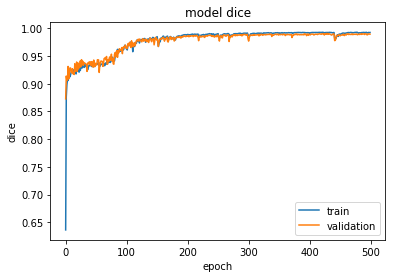

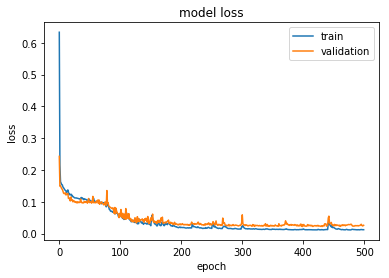

In [8]:
def show_plots(history):
    fig = plt.figure()
    plt.plot(history.history['dice_coef'])
    plt.plot(history.history['val_dice_coef'])
    plt.title('model dice')
    plt.ylabel('dice')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='lower right')
    plt.show()
    fig.savefig(os.path.join(save_imgs_dir,"dice-plot.png"))
    
    fig2 = plt.figure()
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.show()
    fig2.savefig(os.path.join(save_imgs_dir,"loss-plot.png"))
    
show_plots(hist)

In [9]:
import tensorflow as tf

model_endo.load_weights(weight_file)

def calculate_dice(images, masks_true,model_in):
    dices = []
    masks_pred = np.concatenate([model_in.predict(image[None,:,:,:]) for image in images])
    for mask_true, mask_pred in zip(masks_true, masks_pred):
        y_true = mask_true[:,:,1].astype('uint8')
        y_pred = np.round(mask_pred[:,:,1]).astype('uint8')
        dices.append(dice_coef_np(y_true.flatten(), y_pred.flatten()))
    print("Dice Average: {:.2f} Dice Stdev: {:.2f}".format(np.mean(dices), np.std(dices)))

In [10]:
print("Training Statistics(No Dropout)...")
calculate_dice(train_images, train_inner_masks,model_endo)
print("Validation Statistics(No Dropout)...")
calculate_dice(validation_images, validation_inner_masks,model_endo)

Training Statistics(No Dropout)...
Dice Average: 0.90 Dice Stdev: 0.11
Validation Statistics(No Dropout)...
Dice Average: 0.76 Dice Stdev: 0.28


# View Predictions on Validation Set

/usr/local/lib/python3.5/dist-packages/matplotlib/pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


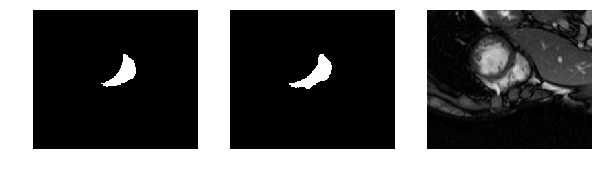

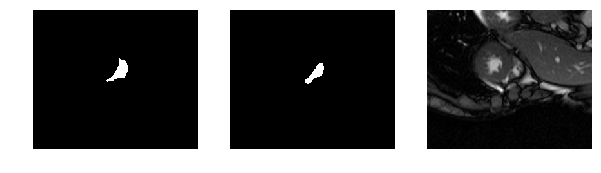

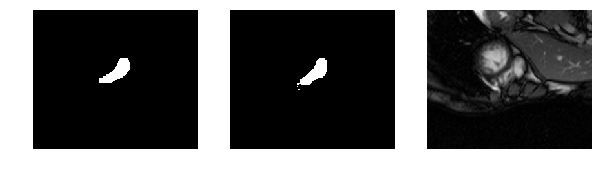

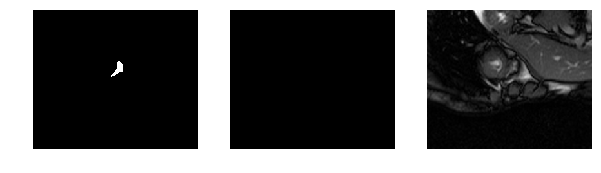

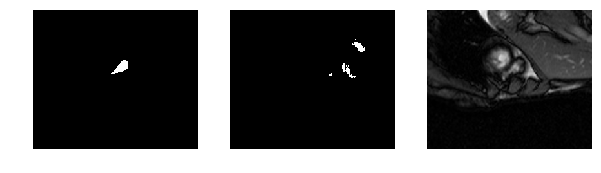

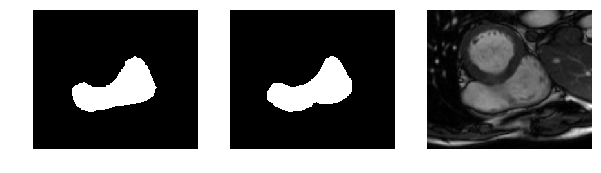

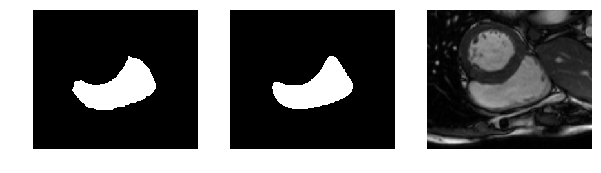

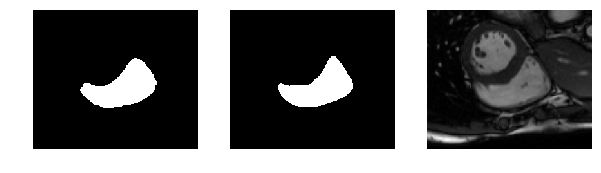

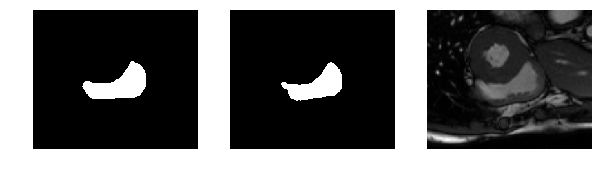

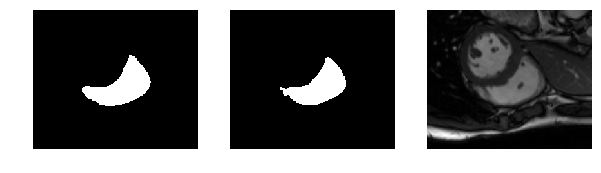

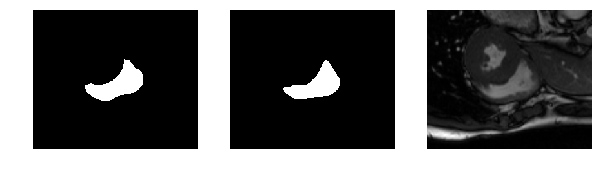

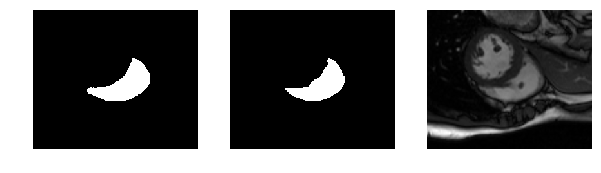

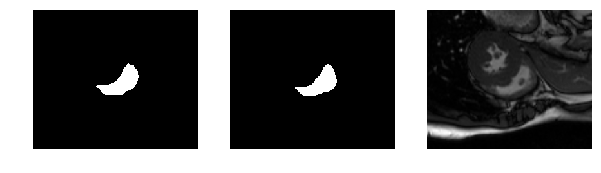

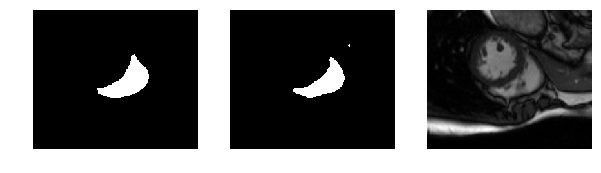

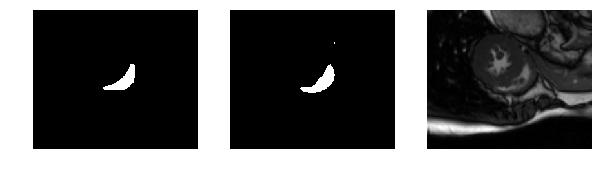

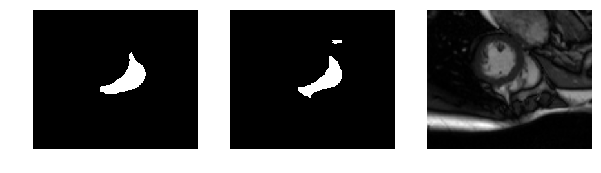

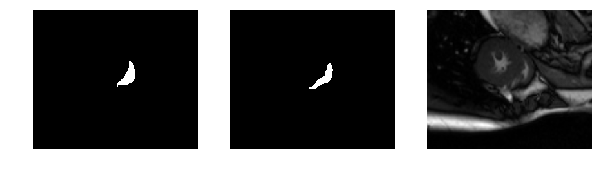

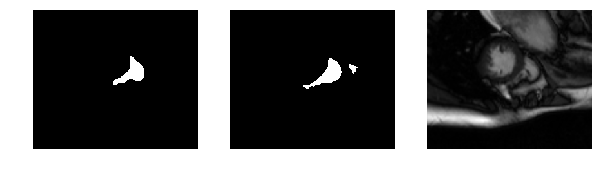

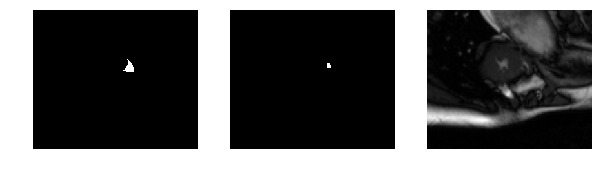

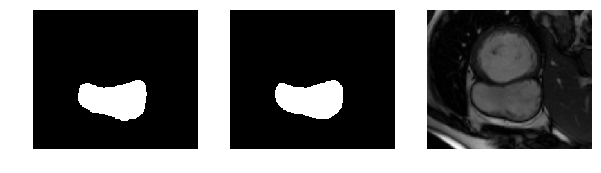

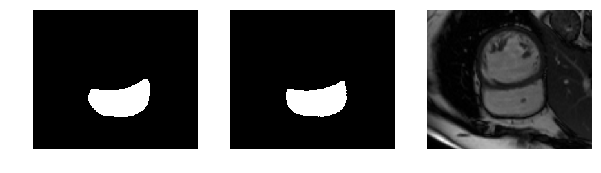

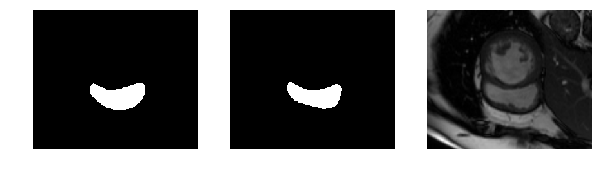

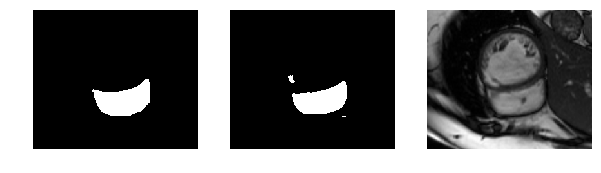

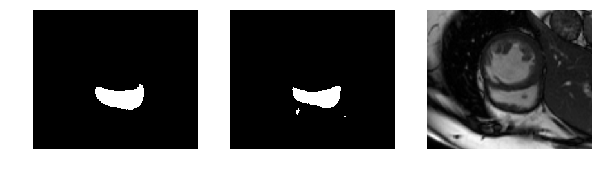

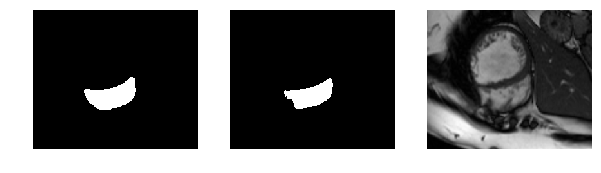

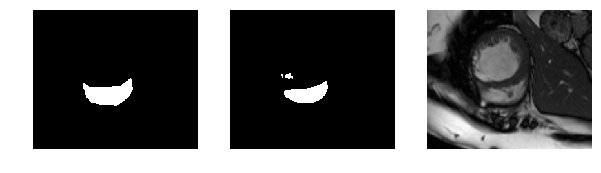

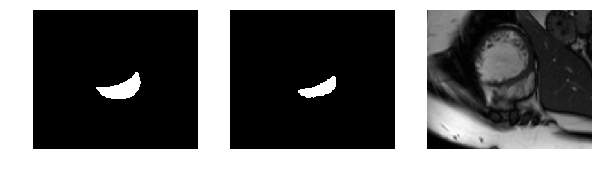

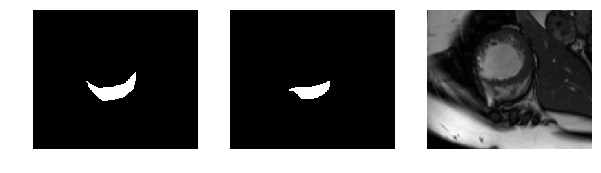

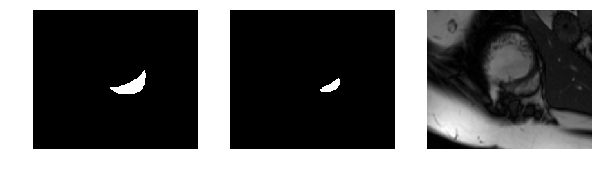

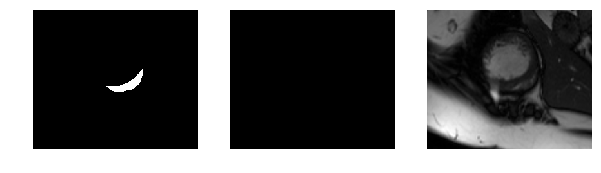

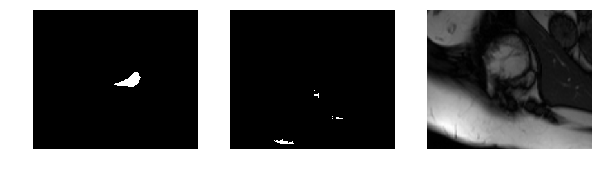

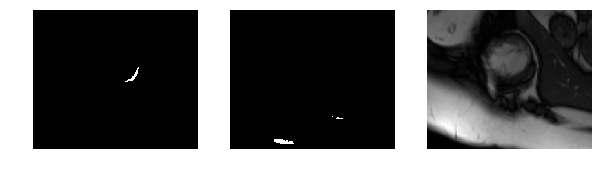

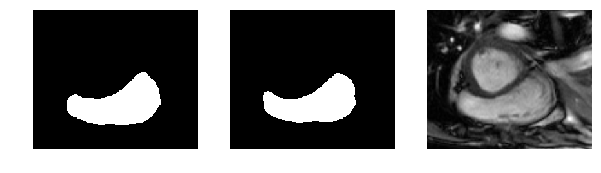

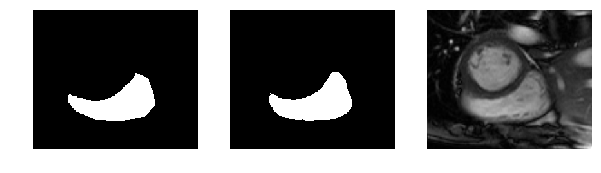

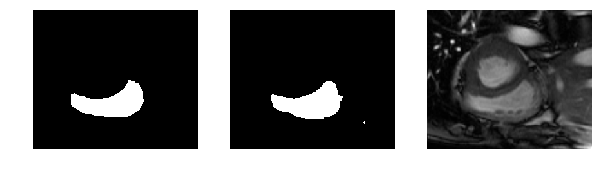

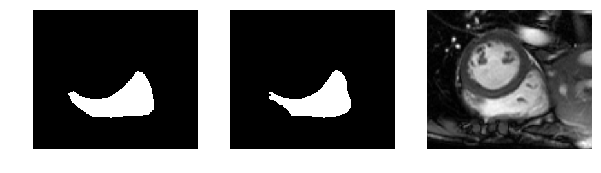

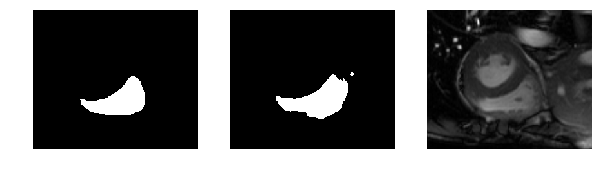

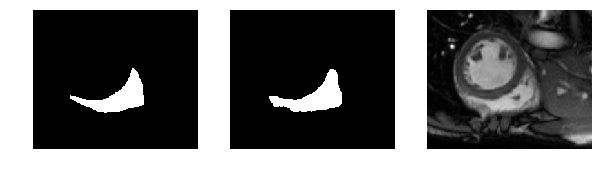

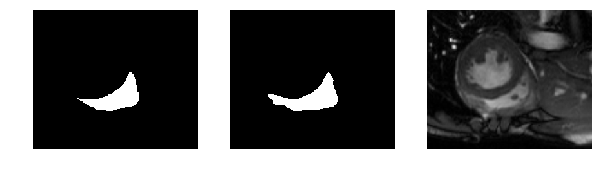

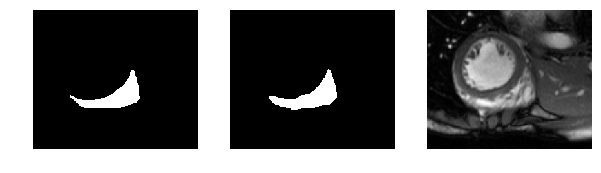

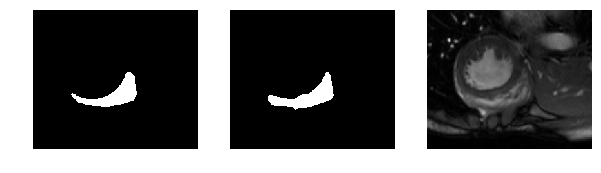

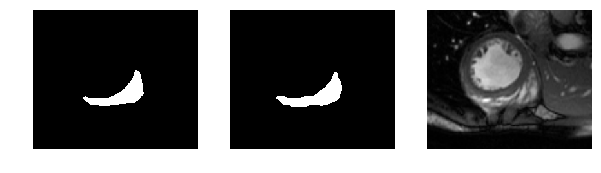

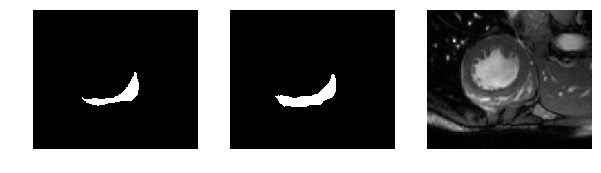

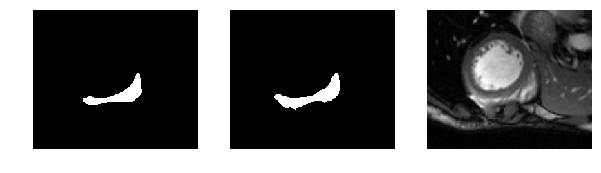

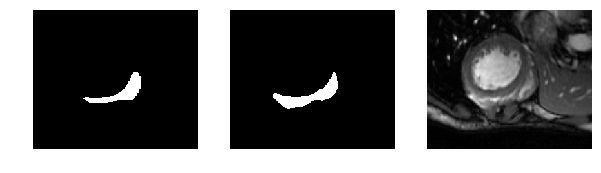

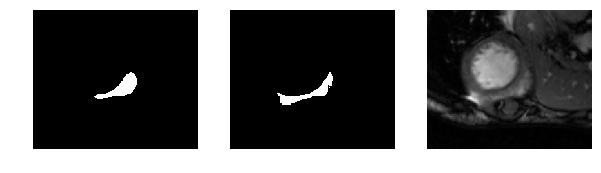

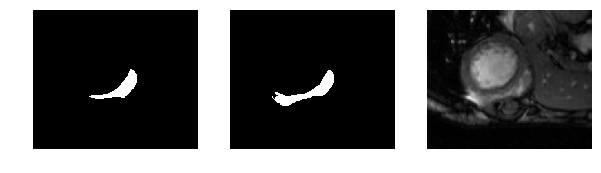

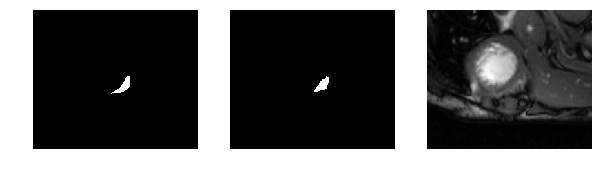

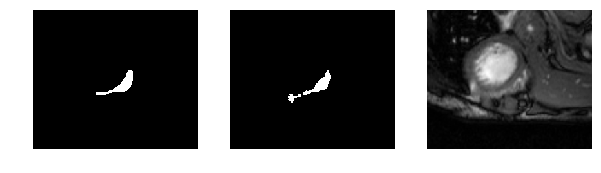

In [11]:
def show_masks(images, i_masks_true,model_in):
    masks_pred = np.concatenate([model_in.predict(image[None,:,:,:]) for image in images])
    counter = 0
    for (image,i_mask,mask_pred) in zip(images,i_masks_true,masks_pred):
        plt.figure(figsize=(10,5))
        plt.subplot(1, 3, 1)
        plt.axis("off")
        plt.imshow(i_mask, cmap=plt.cm.gray)
        plt.subplot(1,3,2)
        plt.axis("off")
        plt.imshow(np.where(mask_pred[:,:,1]>0.5,255,0),cmap=plt.cm.gray)
        plt.subplot(1, 3, 3)
        plt.axis("off")
        plt.imshow(image[:,:,0], cmap=plt.cm.gray)
        counter += 1
        filename = "{:2d}.png".format(counter)
        plt.savefig(os.path.join(save_imgs_dir, filename))
        
show_masks(images[split_index:], inner_masks[split_index:],model_endo)

# Epicardium Model Training

In [12]:
height,width,_ = images[0].shape
dropout=0.0

unet_conv_epi = unet.UNet()

model_epi = unet_conv_epi.get_unet(height=height, width=width, channels=1,features=32,steps=3,dropout=dropout,padding='same')
model_epi.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 216, 256, 1)  0                                            
__________________________________________________________________________________________________
conv2d_16 (Conv2D)              (None, 216, 256, 32) 320         input_2[0][0]                    
__________________________________________________________________________________________________
activation_16 (Activation)      (None, 216, 256, 32) 0           conv2d_16[0][0]                  
__________________________________________________________________________________________________
dropout_15 (Dropout)            (None, 216, 256, 32) 0           activation_16[0][0]              
__________________________________________________________________________________________________
conv2d_17 

In [13]:
model_epi.compile(optimizer=Adam(lr=1e-3),loss=['binary_crossentropy'],metrics=[dice_coef])

In [14]:
train_images_datagen.fit(train_images,augment=True,seed=seed)
train_masks_datagen.fit(train_outer_masks,augment=True,seed=seed)

train_images_generator = train_images_datagen.flow(train_images, y=None, seed=seed)
train_masks_generator = train_images_datagen.flow(train_outer_masks, y=None, seed=seed)


train_generator = zip(train_images_generator, train_masks_generator)

/usr/local/lib/python3.5/dist-packages/Keras-2.1.3-py3.5.egg/keras/preprocessing/image.py:722: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (194, 216, 256, 2) (2 channels).
/usr/local/lib/python3.5/dist-packages/Keras-2.1.3-py3.5.egg/keras/preprocessing/image.py:896: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (194, 216, 256, 2) (2 channels).


In [15]:
checkpointer_epi = ModelCheckpoint(filepath=epi_weight_file, verbose=1, save_best_only=True)

hist_epi = model_epi.fit_generator(train_generator,steps_per_epoch=train_steps,epochs=epochs,verbose=1,callbacks=[checkpointer_epi],
                   validation_data=(validation_images,validation_outer_masks),validation_steps=val_steps)

Epoch 1/500
6/7 [========================>.....] - ETA: 1s - loss: 0.5370 - dice_coef: 0.6390
Epoch 00001: val_loss improved from inf to 0.22626, saving model to saved_models/epi_models/weights-500Epochs-NoDrop-Adam3.hdf5
7/7 [==============================] - 10s 1s/step - loss: 0.4892 - dice_coef: 0.6720 - val_loss: 0.2263 - val_dice_coef: 0.8664
Epoch 2/500
6/7 [========================>.....] - ETA: 1s - loss: 0.2378 - dice_coef: 0.8607
Epoch 00002: val_loss improved from 0.22626 to 0.21328, saving model to saved_models/epi_models/weights-500Epochs-NoDrop-Adam3.hdf5
7/7 [==============================] - 8s 1s/step - loss: 0.2386 - dice_coef: 0.8623 - val_loss: 0.2133 - val_dice_coef: 0.8757
Epoch 3/500
6/7 [========================>.....] - ETA: 1s - loss: 0.2328 - dice_coef: 0.8636
Epoch 00003: val_loss improved from 0.21328 to 0.21131, saving model to saved_models/epi_models/weights-500Epochs-NoDrop-Adam3.hdf5
7/7 [==============================] - 8s 1s/step - loss: 0.2438 - di

6/7 [========================>.....] - ETA: 1s - loss: 0.1461 - dice_coef: 0.9069
Epoch 00027: val_loss did not improve
7/7 [==============================] - 8s 1s/step - loss: 0.1430 - dice_coef: 0.9088 - val_loss: 0.1573 - val_dice_coef: 0.9182
Epoch 28/500
6/7 [========================>.....] - ETA: 1s - loss: 0.1441 - dice_coef: 0.9097
Epoch 00028: val_loss did not improve
7/7 [==============================] - 8s 1s/step - loss: 0.1338 - dice_coef: 0.9158 - val_loss: 0.1521 - val_dice_coef: 0.9146
Epoch 29/500
6/7 [========================>.....] - ETA: 1s - loss: 0.1425 - dice_coef: 0.9097
Epoch 00029: val_loss did not improve
7/7 [==============================] - 8s 1s/step - loss: 0.1397 - dice_coef: 0.9108 - val_loss: 0.1579 - val_dice_coef: 0.9225
Epoch 30/500
6/7 [========================>.....] - ETA: 1s - loss: 0.1442 - dice_coef: 0.9080
Epoch 00030: val_loss did not improve
7/7 [==============================] - 8s 1s/step - loss: 0.1458 - dice_coef: 0.9066 - val_loss: 

Epoch 84/500
6/7 [========================>.....] - ETA: 1s - loss: 0.0848 - dice_coef: 0.9490
Epoch 00084: val_loss did not improve
7/7 [==============================] - 8s 1s/step - loss: 0.0832 - dice_coef: 0.9499 - val_loss: 0.0952 - val_dice_coef: 0.9509
Epoch 85/500
6/7 [========================>.....] - ETA: 1s - loss: 0.0753 - dice_coef: 0.9551
Epoch 00085: val_loss did not improve
7/7 [==============================] - 8s 1s/step - loss: 0.0706 - dice_coef: 0.9572 - val_loss: 0.0846 - val_dice_coef: 0.9529
Epoch 86/500
6/7 [========================>.....] - ETA: 1s - loss: 0.0678 - dice_coef: 0.9621
Epoch 00086: val_loss did not improve
7/7 [==============================] - 8s 1s/step - loss: 0.0685 - dice_coef: 0.9626 - val_loss: 0.0816 - val_dice_coef: 0.9590
Epoch 87/500
6/7 [========================>.....] - ETA: 1s - loss: 0.0703 - dice_coef: 0.9570
Epoch 00087: val_loss improved from 0.08029 to 0.07307, saving model to saved_models/epi_models/weights-500Epochs-NoDrop-A

Epoch 114/500
6/7 [========================>.....] - ETA: 1s - loss: 0.0577 - dice_coef: 0.9622
Epoch 00114: val_loss did not improve
7/7 [==============================] - 8s 1s/step - loss: 0.0554 - dice_coef: 0.9635 - val_loss: 0.0672 - val_dice_coef: 0.9685
Epoch 115/500
6/7 [========================>.....] - ETA: 1s - loss: 0.0544 - dice_coef: 0.9728
Epoch 00115: val_loss did not improve
7/7 [==============================] - 8s 1s/step - loss: 0.0563 - dice_coef: 0.9712 - val_loss: 0.0617 - val_dice_coef: 0.9677
Epoch 116/500
6/7 [========================>.....] - ETA: 1s - loss: 0.0509 - dice_coef: 0.9699
Epoch 00116: val_loss did not improve
7/7 [==============================] - 8s 1s/step - loss: 0.0559 - dice_coef: 0.9668 - val_loss: 0.0556 - val_dice_coef: 0.9656
Epoch 117/500
6/7 [========================>.....] - ETA: 1s - loss: 0.0489 - dice_coef: 0.9689
Epoch 00117: val_loss did not improve
7/7 [==============================] - 8s 1s/step - loss: 0.0466 - dice_coef: 0.

Epoch 144/500
6/7 [========================>.....] - ETA: 1s - loss: 0.0324 - dice_coef: 0.9810
Epoch 00144: val_loss did not improve
7/7 [==============================] - 8s 1s/step - loss: 0.0314 - dice_coef: 0.9813 - val_loss: 0.0556 - val_dice_coef: 0.9745
Epoch 145/500
6/7 [========================>.....] - ETA: 1s - loss: 0.0332 - dice_coef: 0.9808
Epoch 00145: val_loss did not improve
7/7 [==============================] - 8s 1s/step - loss: 0.0357 - dice_coef: 0.9805 - val_loss: 0.0662 - val_dice_coef: 0.9742
Epoch 146/500
6/7 [========================>.....] - ETA: 1s - loss: 0.0411 - dice_coef: 0.9754
Epoch 00146: val_loss did not improve
7/7 [==============================] - 8s 1s/step - loss: 0.0393 - dice_coef: 0.9759 - val_loss: 0.0527 - val_dice_coef: 0.9730
Epoch 147/500
6/7 [========================>.....] - ETA: 1s - loss: 0.0378 - dice_coef: 0.9789
Epoch 00147: val_loss did not improve
7/7 [==============================] - 8s 1s/step - loss: 0.0399 - dice_coef: 0.

Epoch 175/500
6/7 [========================>.....] - ETA: 1s - loss: 0.0274 - dice_coef: 0.9838
Epoch 00175: val_loss did not improve
7/7 [==============================] - 8s 1s/step - loss: 0.0365 - dice_coef: 0.9802 - val_loss: 0.0555 - val_dice_coef: 0.9708
Epoch 176/500
6/7 [========================>.....] - ETA: 1s - loss: 0.0542 - dice_coef: 0.9708
Epoch 00176: val_loss did not improve
7/7 [==============================] - 8s 1s/step - loss: 0.0506 - dice_coef: 0.9721 - val_loss: 0.0600 - val_dice_coef: 0.9656
Epoch 177/500
6/7 [========================>.....] - ETA: 1s - loss: 0.0541 - dice_coef: 0.9661
Epoch 00177: val_loss did not improve
7/7 [==============================] - 8s 1s/step - loss: 0.0518 - dice_coef: 0.9673 - val_loss: 0.0479 - val_dice_coef: 0.9731
Epoch 178/500
6/7 [========================>.....] - ETA: 1s - loss: 0.0373 - dice_coef: 0.9781
Epoch 00178: val_loss did not improve
7/7 [==============================] - 8s 1s/step - loss: 0.0474 - dice_coef: 0.

Epoch 205/500
6/7 [========================>.....] - ETA: 1s - loss: 0.0252 - dice_coef: 0.9862
Epoch 00205: val_loss did not improve
7/7 [==============================] - 8s 1s/step - loss: 0.0254 - dice_coef: 0.9859 - val_loss: 0.0376 - val_dice_coef: 0.9810
Epoch 206/500
6/7 [========================>.....] - ETA: 1s - loss: 0.0234 - dice_coef: 0.9857
Epoch 00206: val_loss did not improve
7/7 [==============================] - 8s 1s/step - loss: 0.0232 - dice_coef: 0.9856 - val_loss: 0.0418 - val_dice_coef: 0.9822
Epoch 207/500
6/7 [========================>.....] - ETA: 1s - loss: 0.0231 - dice_coef: 0.9866
Epoch 00207: val_loss did not improve
7/7 [==============================] - 8s 1s/step - loss: 0.0223 - dice_coef: 0.9869 - val_loss: 0.0377 - val_dice_coef: 0.9823
Epoch 208/500
6/7 [========================>.....] - ETA: 1s - loss: 0.0226 - dice_coef: 0.9870
Epoch 00208: val_loss did not improve
7/7 [==============================] - 8s 1s/step - loss: 0.0242 - dice_coef: 0.

Epoch 236/500
6/7 [========================>.....] - ETA: 1s - loss: 0.0225 - dice_coef: 0.9873
Epoch 00236: val_loss did not improve
7/7 [==============================] - 8s 1s/step - loss: 0.0215 - dice_coef: 0.9876 - val_loss: 0.0402 - val_dice_coef: 0.9836
Epoch 237/500
6/7 [========================>.....] - ETA: 1s - loss: 0.0222 - dice_coef: 0.9871
Epoch 00237: val_loss did not improve
7/7 [==============================] - 8s 1s/step - loss: 0.0236 - dice_coef: 0.9868 - val_loss: 0.0403 - val_dice_coef: 0.9820
Epoch 238/500
6/7 [========================>.....] - ETA: 1s - loss: 0.0237 - dice_coef: 0.9858
Epoch 00238: val_loss did not improve
7/7 [==============================] - 8s 1s/step - loss: 0.0228 - dice_coef: 0.9863 - val_loss: 0.0479 - val_dice_coef: 0.9819
Epoch 239/500
6/7 [========================>.....] - ETA: 1s - loss: 0.0240 - dice_coef: 0.9858
Epoch 00239: val_loss did not improve
7/7 [==============================] - 8s 1s/step - loss: 0.0242 - dice_coef: 0.

Epoch 297/500
6/7 [========================>.....] - ETA: 1s - loss: 0.0167 - dice_coef: 0.9897
Epoch 00297: val_loss did not improve
7/7 [==============================] - 8s 1s/step - loss: 0.0172 - dice_coef: 0.9895 - val_loss: 0.0393 - val_dice_coef: 0.9857
Epoch 298/500
6/7 [========================>.....] - ETA: 1s - loss: 0.0172 - dice_coef: 0.9896
Epoch 00298: val_loss did not improve
7/7 [==============================] - 8s 1s/step - loss: 0.0172 - dice_coef: 0.9895 - val_loss: 0.0375 - val_dice_coef: 0.9855
Epoch 299/500
6/7 [========================>.....] - ETA: 1s - loss: 0.0170 - dice_coef: 0.9895
Epoch 00299: val_loss did not improve
7/7 [==============================] - 8s 1s/step - loss: 0.0165 - dice_coef: 0.9897 - val_loss: 0.0368 - val_dice_coef: 0.9863
Epoch 300/500
6/7 [========================>.....] - ETA: 1s - loss: 0.0175 - dice_coef: 0.9895
Epoch 00300: val_loss did not improve
7/7 [==============================] - 8s 1s/step - loss: 0.0170 - dice_coef: 0.

6/7 [========================>.....] - ETA: 1s - loss: 0.0159 - dice_coef: 0.9904
Epoch 00359: val_loss did not improve
7/7 [==============================] - 8s 1s/step - loss: 0.0161 - dice_coef: 0.9903 - val_loss: 0.0417 - val_dice_coef: 0.9861
Epoch 360/500
6/7 [========================>.....] - ETA: 1s - loss: 0.0158 - dice_coef: 0.9903
Epoch 00360: val_loss did not improve
7/7 [==============================] - 8s 1s/step - loss: 0.0154 - dice_coef: 0.9903 - val_loss: 0.0391 - val_dice_coef: 0.9865
Epoch 361/500
6/7 [========================>.....] - ETA: 1s - loss: 0.0152 - dice_coef: 0.9907
Epoch 00361: val_loss did not improve
7/7 [==============================] - 8s 1s/step - loss: 0.0152 - dice_coef: 0.9908 - val_loss: 0.0418 - val_dice_coef: 0.9866
Epoch 362/500
6/7 [========================>.....] - ETA: 1s - loss: 0.0160 - dice_coef: 0.9906
Epoch 00362: val_loss did not improve
7/7 [==============================] - 8s 1s/step - loss: 0.0156 - dice_coef: 0.9906 - val_los

6/7 [========================>.....] - ETA: 1s - loss: 0.0158 - dice_coef: 0.9903
Epoch 00421: val_loss did not improve
7/7 [==============================] - 8s 1s/step - loss: 0.0156 - dice_coef: 0.9903 - val_loss: 0.0439 - val_dice_coef: 0.9865
Epoch 422/500
6/7 [========================>.....] - ETA: 1s - loss: 0.0149 - dice_coef: 0.9909
Epoch 00422: val_loss did not improve
7/7 [==============================] - 8s 1s/step - loss: 0.0156 - dice_coef: 0.9905 - val_loss: 0.0383 - val_dice_coef: 0.9855
Epoch 423/500
6/7 [========================>.....] - ETA: 1s - loss: 0.0153 - dice_coef: 0.9905
Epoch 00423: val_loss did not improve
7/7 [==============================] - 8s 1s/step - loss: 0.0151 - dice_coef: 0.9906 - val_loss: 0.0388 - val_dice_coef: 0.9865
Epoch 424/500
6/7 [========================>.....] - ETA: 1s - loss: 0.0145 - dice_coef: 0.9910
Epoch 00424: val_loss did not improve
7/7 [==============================] - 8s 1s/step - loss: 0.0141 - dice_coef: 0.9912 - val_los

Epoch 483/500
6/7 [========================>.....] - ETA: 1s - loss: 0.0162 - dice_coef: 0.9900
Epoch 00483: val_loss did not improve
7/7 [==============================] - 8s 1s/step - loss: 0.0165 - dice_coef: 0.9899 - val_loss: 0.0395 - val_dice_coef: 0.9848
Epoch 484/500
6/7 [========================>.....] - ETA: 1s - loss: 0.0158 - dice_coef: 0.9903
Epoch 00484: val_loss did not improve
7/7 [==============================] - 8s 1s/step - loss: 0.0166 - dice_coef: 0.9901 - val_loss: 0.0442 - val_dice_coef: 0.9838
Epoch 485/500
6/7 [========================>.....] - ETA: 1s - loss: 0.0165 - dice_coef: 0.9898
Epoch 00485: val_loss did not improve
7/7 [==============================] - 8s 1s/step - loss: 0.0163 - dice_coef: 0.9899 - val_loss: 0.0408 - val_dice_coef: 0.9844
Epoch 486/500
6/7 [========================>.....] - ETA: 1s - loss: 0.0159 - dice_coef: 0.9902
Epoch 00486: val_loss did not improve
7/7 [==============================] - 8s 1s/step - loss: 0.0158 - dice_coef: 0.

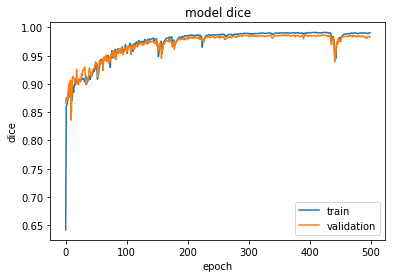

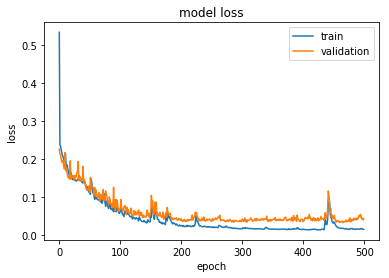

In [16]:
def show_plots(history):
    fig = plt.figure()
    plt.plot(history.history['dice_coef'])
    plt.plot(history.history['val_dice_coef'])
    plt.title('model dice')
    plt.ylabel('dice')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='lower right')
    plt.show()
    fig.savefig(os.path.join(save_imgs_dir_epi,"dice-plot.png"))
    
    fig2 = plt.figure()
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.show()
    fig2.savefig(os.path.join(save_imgs_dir_epi,"loss-plot.png"))
    
show_plots(hist_epi)

In [17]:
import tensorflow as tf

model_epi.load_weights(epi_weight_file)

def calculate_dice(images, masks_true,model_in):
    dices = []
    masks_pred = np.concatenate([model_in.predict(image[None,:,:,:]) for image in images])
    for mask_true, mask_pred in zip(masks_true, masks_pred):
        y_true = mask_true[:,:,1].astype('uint8')
        y_pred = np.round(mask_pred[:,:,1]).astype('uint8')
        dices.append(dice_coef_np(y_true.flatten(), y_pred.flatten()))
    print("Dice Average: {:.2f} Dice Stdev: {:.2f}".format(np.mean(dices), np.std(dices)))

In [18]:
print("Training Statistics(No Dropout)...")
calculate_dice(train_images, train_outer_masks,model_epi)
print("Validation Statistics(No Dropout)...")
calculate_dice(validation_images, validation_outer_masks,model_epi)

Training Statistics(No Dropout)...
Dice Average: 0.93 Dice Stdev: 0.08
Validation Statistics(No Dropout)...
Dice Average: 0.78 Dice Stdev: 0.29


/usr/local/lib/python3.5/dist-packages/matplotlib/pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


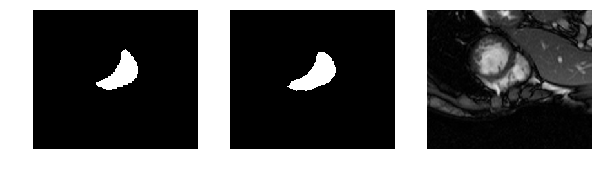

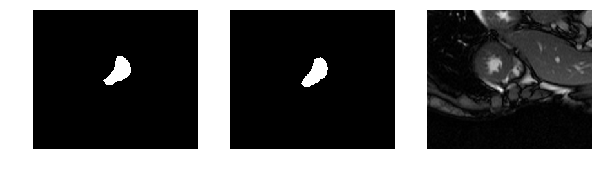

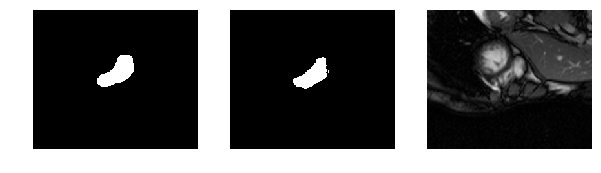

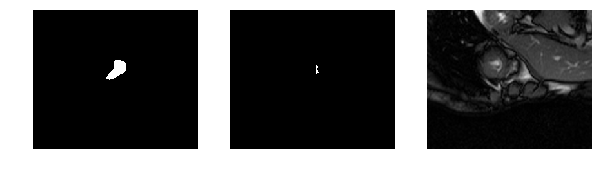

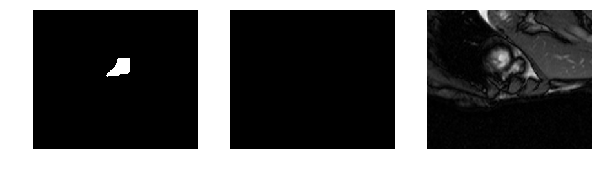

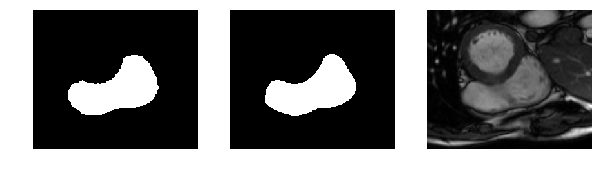

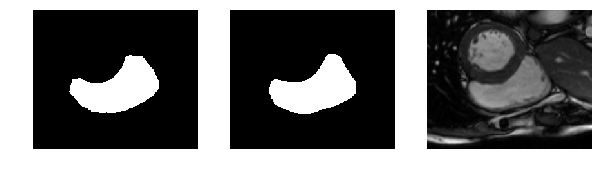

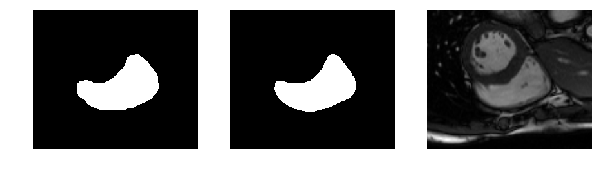

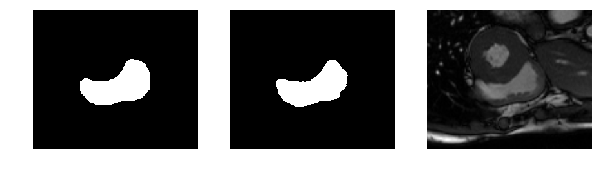

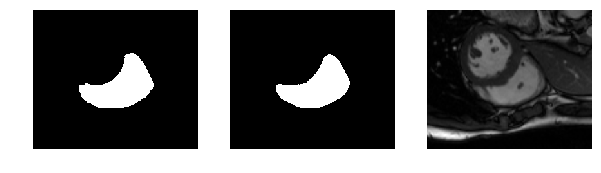

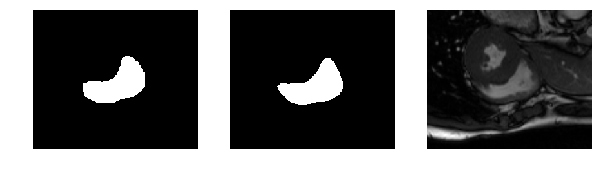

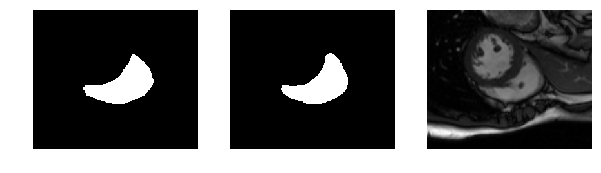

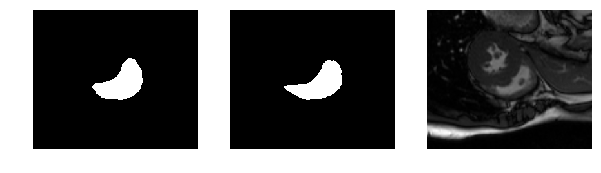

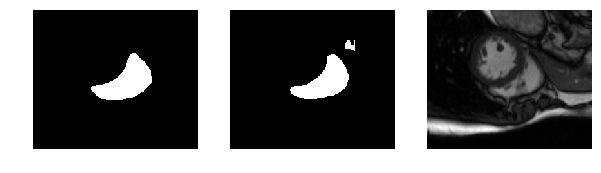

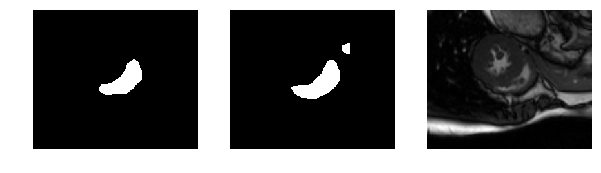

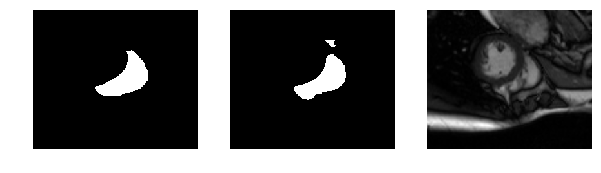

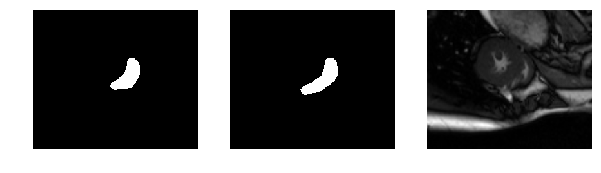

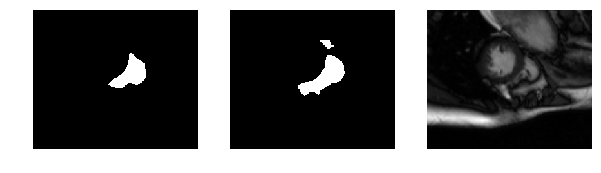

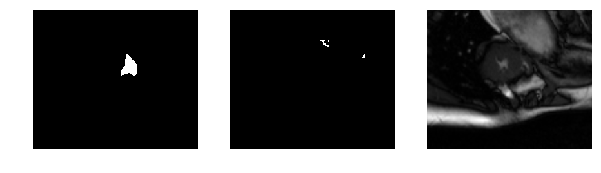

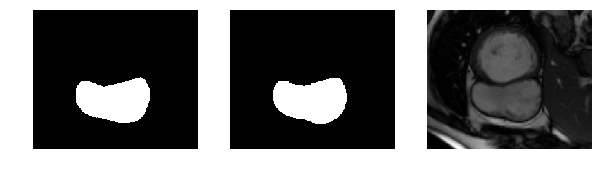

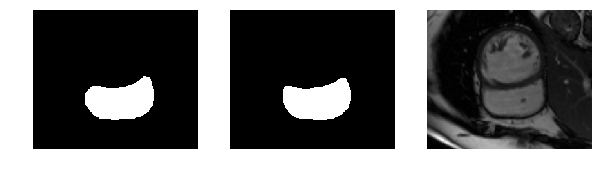

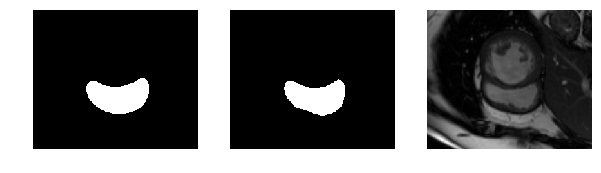

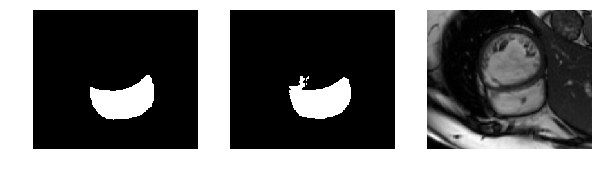

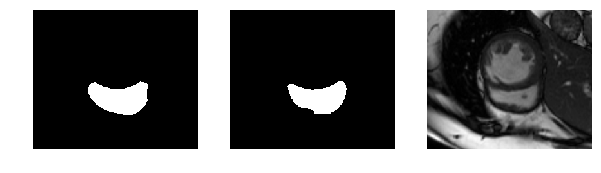

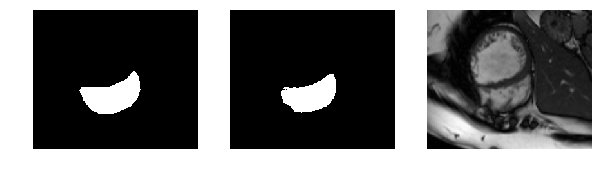

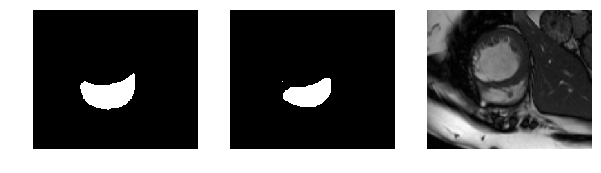

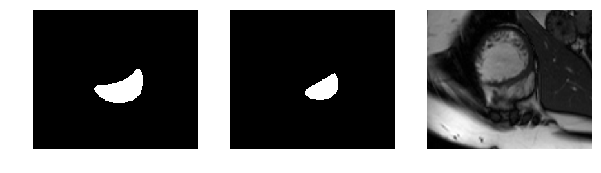

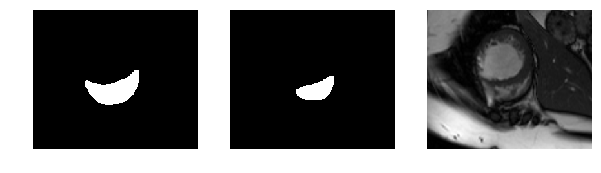

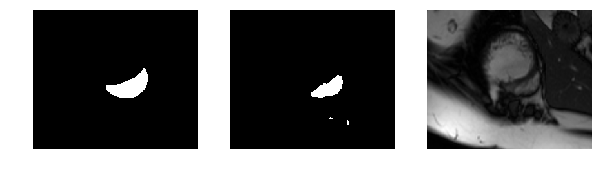

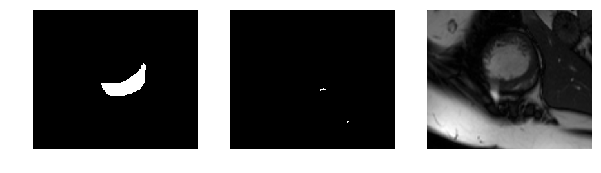

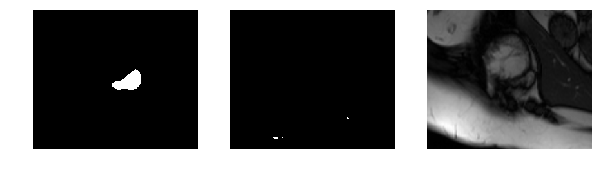

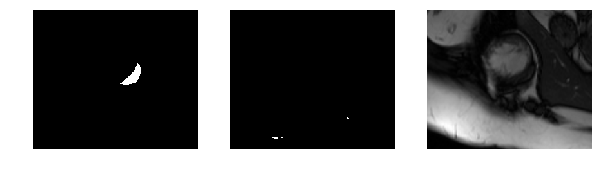

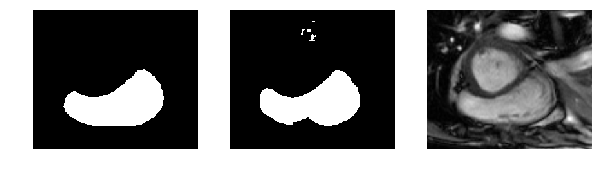

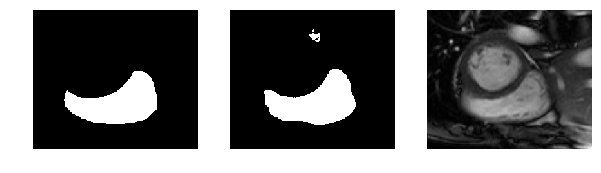

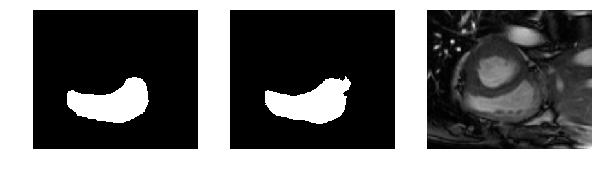

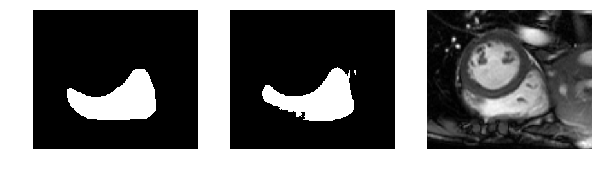

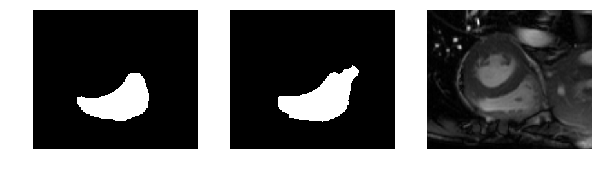

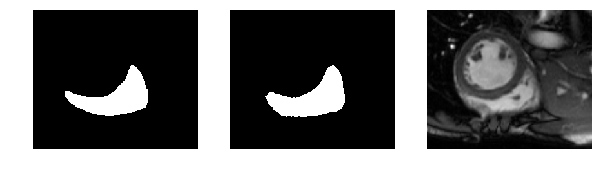

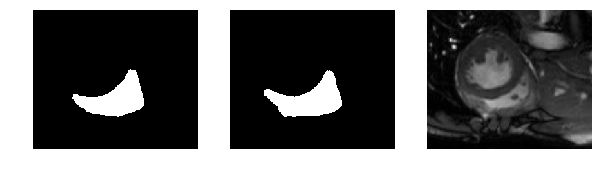

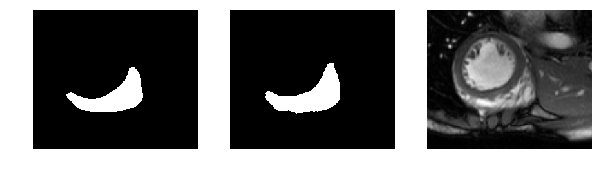

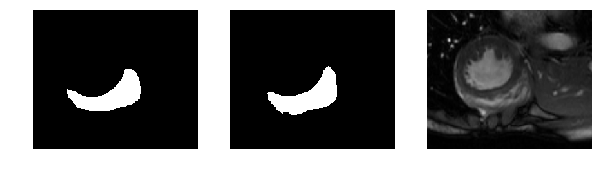

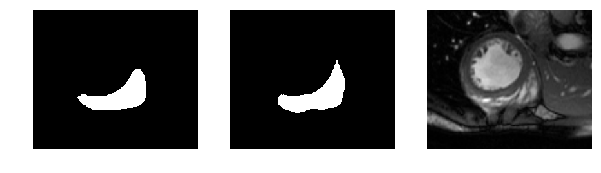

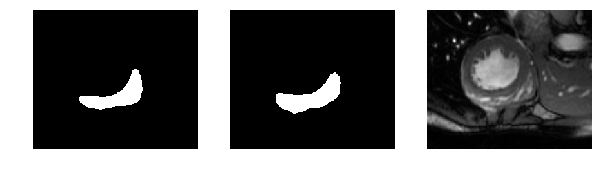

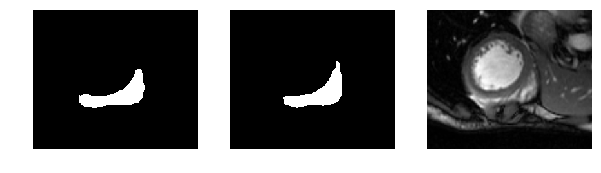

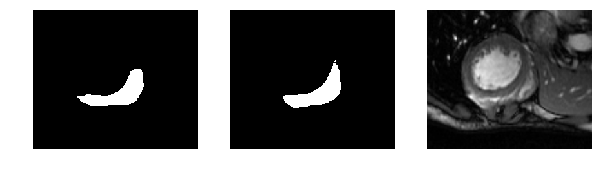

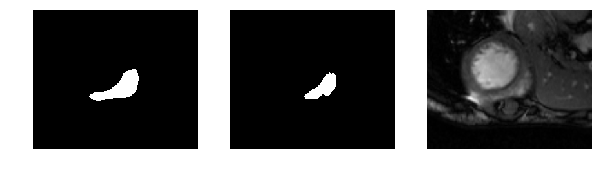

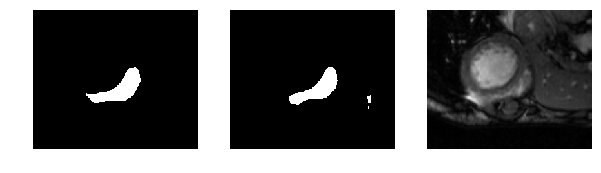

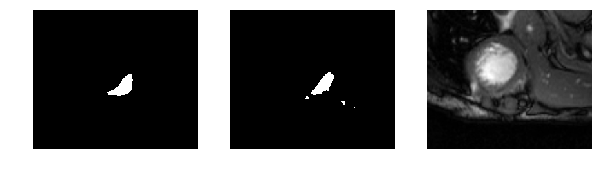

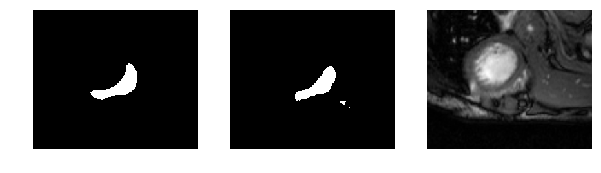

In [19]:
def show_masks(images, i_masks_true,model_in):
    masks_pred = np.concatenate([model_in.predict(image[None,:,:,:]) for image in images])
    counter = 0
    for (image,i_mask,mask_pred) in zip(images,i_masks_true,masks_pred):
        plt.figure(figsize=(10,5))
        plt.subplot(1, 3, 1)
        plt.axis("off")
        plt.imshow(i_mask, cmap=plt.cm.gray)
        plt.subplot(1,3,2)
        plt.axis("off")
        plt.imshow(np.round(mask_pred[:,:,1]),cmap=plt.cm.gray)
        plt.subplot(1, 3, 3)
        plt.axis("off")
        plt.imshow(image[:,:,0], cmap=plt.cm.gray)
        counter += 1
        filename = "{:2d}.png".format(counter)
        plt.savefig(os.path.join(save_imgs_dir_epi, filename))
        
show_masks(images[split_index:], outer_masks[split_index:],model_epi)